<a href="https://colab.research.google.com/github/BurgundyIsAPublicEnemy/EPIDEMIUM-Season-3/blob/main/Run_Model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train and create a submission model
Set up your variables below (make sure they point to the right place) and hit run. Let the model do it's thing

Remember to use a GPU Runtime!

In [13]:
!pip install python-dotenv
!pip install colab-env --upgrade
!pip install pytorch_lightning

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import colab_env

colab_env.__version__

'0.2.0'

In [16]:
!more /content/drive/MyDrive/vars.env

IMAGEFILES = 'WHERE YOUR DATAIKU IMAGES ARE LOCATED'
TABULARTRAINING = 'WHERE THE TRAINNG CSV IS AT'
TABULARTEST = 'WHERE THE TEST CSV IS AT '
FULLSTACKTRAIN = 'WHERE YOUR TIFS ARE'
TRAIN_AUGMENTED_PATH = 'WHERE YOU WANT TO PUT YOUR NEW TRAINING CSV'
TEST_AUGMENTED_PATH = 'WHERE YOU WANT TO PUT YOUR NEW TEST CSV'
METADATA_PATH = ''
TENPERCENT_MODEL_PATH = '/content/drive/MyDrive/Kaggle/ModelDump/tenpercent_resn
et18.ckpt'
IMG_TO_ANALYZE = '/content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v
2/Cellule inflamatoire 2/a4ad44_[12800,52067]_composite_image.jpg'
FOLDER_TO_OUTPUT = './'
OUTPUT_MODEL_PATH = '/content/drive/MyDrive/Kaggle/ModelDump/'
WORKSPACE_PATH = '/content/drive/MyDrive/Kaggle/ORLIA'
MODEL_PATH = '/content/drive/MyDrive/Kaggle/ModelDump/fold_0.pth'
patience = 1


In [17]:
import os

TEN_PERCENT_MODEL_PATH = os.getenv("TENPERCENT_MODEL_PATH")
patience = int(os.getenv("patience"))
WORKSPACE_PATH = os.getenv("WORKSPACE_PATH")

OUTPUT_MODEL_PATH = os.getenv("OUTPUT_MODEL_PATH")

In [18]:
print(OUTPUT_MODEL_PATH)

/content/drive/MyDrive/Kaggle/ModelDump/


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os 
from tqdm import tqdm

import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import Adam
from torch.nn import L1Loss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

from torchvision.io import read_image
from google.colab.patches import cv2_imshow


from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

In [20]:
# Config Class
class Config:
    def __init__(self):
        self.FOLDS = 5
        self.EPOCHS = 30
        self.DEVICE = 'cuda'
        self.TRAIN_BS = 16
        self.VALID_BS = 8
        self.loss_fn = nn.L1Loss()

config = Config()

In [21]:
path = Path(WORKSPACE_PATH)
path.ls()

[PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/Train'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/Test'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/train_img_data.csv'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/train_minus_hold_img_data.csv'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/holdout_img_data.csv'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/test_img_data.csv'),
 PosixPath('/content/drive/MyDrive/Kaggle/ORLIA/.ipynb_checkpoints')]

## Data Prep & Loading 

In [22]:
# get train 
train_df = pd.read_csv(str(path.ls()[2]))
test_df = pd.read_csv(str(path.ls()[5]))

In [23]:
# unique patinet ids 
unique_patient_ids = train_df.id.unique()
len(unique_patient_ids)

42

In [24]:
unique_patient_ids

array(['afdc1c', 'b3c9bb', 'b41668', 'a4fa68', 'b1abe7', 'adc0ca',
       'b32f11', 'af8dca', 'aba442', 'b293e2', 'b02926', 'b110d5',
       'abf1b4', 'b4b14e', 'ab55eb', 'ad7219', 'b4fddb', 'b5e396',
       'a801cb', 'b1fa79', 'a8ebaf', 'b59738', 'aa21da', 'b6cb24',
       'ae5b78', 'b075a7', 'af4155', 'acd8f0', 'a54803', 'a4ad44',
       'a85076', 'aa6e3d', 'a6cafe', 'a89f20', 'b67e5a', 'a93ad8',
       'aea82d', 'a67dfe', 'a5969b', 'b2e232', 'b0c41b', 'b24726'],
      dtype=object)

## Dataset

In [25]:
train_df.columns

Index(['id', 'usage', 'image_file', 'image_rename', 'current_directory',
       'layer', 'img_type', 'OMS', 'sexe (0=F 1=M)', 'DDN', 'Date biopsie',
       'Age au diag', 'Deces Code', 'Code recidive', 'localisation',
       'RNAscope', 'T', 'N', 'M', 'Tabac', 'Alcool', 'Data', 'OS',
       'id_encoding', 'image_rename_encoding'],
      dtype='object')

In [26]:
train_cols_to_drop = ['id' , 'usage' ,'image_file' ,'image_rename' ,'current_directory' ,'layer' ,'img_type' ,'N' ,'Data' ,'id_encoding' ,'image_rename_encoding', 'OS', 'DDN', 'Date biopsie']

In [27]:
class Dataset:
    def __init__(self, path, df, folder = 'Train', is_train = 1):
      """Summary or Description of the Function
      
      Parameters:
      path (Path): path of drive folder that contains csvs and train / test image folders 
      df (Pandas df )  : sub fold dataframe for fold patients 
      folder (str) : train or test folder 
      
      Returns:
      img , tab and target 
      
      """

      self.df = df
      self.folder = folder
      self.path = path 
      self.is_train = is_train
      
      self.train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor()
                ])
        
      self.test_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()])
      
    def __len__(self):
      return len(self.df)
    
    def __getitem__(self,idx):

      row = self.df.loc[idx,:]
      pid = row['id']
      sub_df = self.df[self.df['id'] == pid]
        
      try: 
     
        img_id = np.random.choice(len(sub_df)) # randomly choose a patient image inside the fold 
        image = cv2.imread(str(self.path)  + '/' + self.folder + '/' + sub_df.iloc[img_id,:]['image_rename'])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        img = self.train_transform(image) if self.is_train else self.test_transform(image)
         
        tab = torch.from_numpy(sub_df.iloc[img_id,:].drop(train_cols_to_drop).values.astype(np.float)).float() # dtype = torch.float32
        target = torch.tensor(row['OS'])
        return (img,tab), target , torch.tensor(sub_df.iloc[img_id]['id_encoding']) , torch.tensor(sub_df.iloc[img_id]['image_rename_encoding'])
        
      except Exception as e:
        print(e)
        print(pid, img_id)

## Collate Function 

In [28]:
def collate_fn(b):
    xs, ys, pids,img_rename = zip(*b)
    imgs, tabs = zip(*xs) # doule tuple 
    return (torch.stack(imgs).float(),torch.stack(tabs).float()),torch.stack(ys).float() , torch.stack(pids) , torch.stack(img_rename)

## Generating Splits 

In [29]:
from sklearn.model_selection import KFold

def get_split_idxs(n_folds=5):
    kv = KFold(n_splits=n_folds)
    splits = []
    for i,(train_idx, valid_idx) in enumerate(kv.split(unique_patient_ids)):
        splits.append((train_idx, valid_idx))
        
    return splits

In [30]:
splits = get_split_idxs(n_folds=config.FOLDS)

In [31]:
splits

[(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]),
  array([ 9, 10, 11, 12, 13, 14, 15, 16, 17])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]),
  array([18, 19, 20, 21, 22, 23, 24, 25])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 34, 35, 36, 37, 38, 39, 40, 41]),
  array([26, 27, 28, 29, 30, 31, 32, 33])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
  array([34, 35, 36, 37, 38, 39, 40, 41]))]

# Training propsed model

GOAL:
```
Image Data --> CNNLayer 
                    \
                     ---> FCLayer ---> Output
                    /
Metadata --> FCLayer
```



## Loading Supervised Pretrained 

Original paper: https://arxiv.org/pdf/2011.13971.pdf

Repo: https://github.com/ozanciga/self-supervised-histopathology/tree/tenpercent

In [32]:
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 1  # only used if RETURN_PREACTIVATION = False


def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = torchvision.models.__dict__['resnet18'](pretrained=False)
state = torch.load(TEN_PERCENT_MODEL_PATH, map_location='cuda:0')

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.cuda()

images = torch.rand((10, 3, 224, 224), device='cuda')

out = model(images)


for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
    
    model.fc = torch.nn.Linear(512, 256,bias = True) 
    model = model.cuda()


In [33]:
import copy

proposed_model = copy.deepcopy(model)

count = 1
for param in proposed_model.parameters():
  count += 1

cur = 1
for param in proposed_model.parameters():
  if (cur > (0.8 * count)): 
    param.requires_grad = True
  cur += 1

proposed_model = proposed_model.cuda()

## Training Global Model 

In [34]:
def train_loop(model, dl, opt , device, loss_fn):
    model.train()
    final_loss = []
    for X,y,_,_ in dl:
        imgs = X[0].to(device)
        tabs = X[1].to(device)
        y = y.to(device)
        outputs = model(imgs, tabs)
        loss = loss_fn(outputs.squeeze(), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        final_loss.append(loss.detach().cpu().numpy())
        #print('Training Example preds vs targets: ::\t \n' , outputs , '\n' , y)
    return np.array(final_loss).mean()
    
def eval_loop(model, dl, device, loss_fn):
    model.eval()
    final_outputs = []
    final_loss = []
    with torch.no_grad():
        for X,y,_,_ in dl:
            imgs = X[0].to(device)
            tabs = X[1].to(device)
            y=y.to(device)

            outputs = model(imgs, tabs)
            loss = loss_fn(outputs.squeeze(), y)

            final_outputs.extend(outputs.detach().cpu().numpy().tolist())
            final_loss.append(loss.detach().cpu().numpy())

    print('validation Example preds vs targets: ::\t \n' , outputs , '\n' , y)
    return final_outputs, final_loss

In [35]:
class Global_Model(nn.Module): # model to combina both tab and imag 
    def __init__(self , pretrained_medical_resnet):
        super().__init__()
        self.conv_model = pretrained_medical_resnet # after freezing some layers and setting regression node as 1 not 4 
        self.tab_model = nn.Sequential(nn.Linear(11, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500,250),
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
                                  
        self.output =             nn.Sequential(
                                                nn.Linear(250 + 256 ,250),
                                                nn.ReLU(),
                                                nn.Dropout(p=0.3),
                                                nn.Linear(250, 125),
                                                nn.ReLU(),
                                                nn.Dropout(p=0.3),
                                                nn.Linear(125, 60),
                                                nn.ReLU(),
                                                nn.Dropout(p=0.3),
                                                nn.Linear(60, 20),
                                                nn.ReLU(),
                                                nn.Dropout(p=0.3),
                                                nn.Linear(20, 1, bias = True ))
    def forward(self, x,tab): # x image , tab is tabular data related 
        x = self.conv_model(x)
        tab_out = self.tab_model(tab)
        x = torch.cat([x, tab_out],dim=1)
        return self.output(x)

In [36]:
models = {}
for i in range(config.FOLDS):
    models[i] = copy.deepcopy(Global_Model(copy.deepcopy(proposed_model)))  

In [37]:
history = []
trainhistory = []

bestModels = []
bestScores = []

for i, (train_idx, valid_idx) in enumerate(splits):
    bestModel = None
    bestHistory = 100

    print(f"===================Fold : {i} ================")
    print("train_idx : " , train_idx , "\n valid_idx" , valid_idx)

    train = train_df.loc[train_df['id'].isin(unique_patient_ids[train_idx])].reset_index(drop=True)
    valid = train_df.loc[train_df['id'].isin(unique_patient_ids[valid_idx])].reset_index(drop=True)
    
    train_ds = Dataset(path, train,'Train' ,1)
    train_dl = torch.utils.data.DataLoader(dataset=train_ds,batch_size=config.TRAIN_BS,shuffle=True,collate_fn=collate_fn)

    valid_ds = Dataset(path, valid,'Train' ,0)
    valid_dl = torch.utils.data.DataLoader(dataset=valid_ds,batch_size=config.VALID_BS, shuffle=True,collate_fn=collate_fn)

    model = models[i]
    model.to(config.DEVICE)
    lr=1e-3
    momentum = 0.9
    
    num_steps = len(train_dl)
    optimizer = Adam(model.parameters(), lr=lr,weight_decay=0.01)

    train_losses = []
    losses = []
    for epoch in range(config.EPOCHS):
        print(f"=================EPOCHS {epoch+1}================")
        train_loss = train_loop(model, train_dl, optimizer, config.DEVICE,config.loss_fn)
        metrics = eval_loop(model, valid_dl, config.DEVICE,config.loss_fn)
        total_loss = np.array(metrics[1]).mean()

        if (total_loss < bestHistory):
          print('New best model! Score: ', total_loss)
          patienceCounter = 0
          bestHistory = total_loss
          bestModel = copy.deepcopy(model)
        
        if (epoch > patienceCounter):
          if (total_loss >  bestHistory):
            patienceCounter += 1
            print('BAD! Patience counter : ', patienceCounter)

        
        if (patienceCounter >= patience):
          print('Early stopping saved')
          break
        
        losses.append(total_loss)
        train_losses.append(train_loss)
        print('Train Loss:: \t', train_loss)
        print("Validation Loss ::\t", total_loss)
        
    model.to('cpu')

    history.append(losses)
    bestModels.append(bestModel)
    bestScores.append(bestHistory)

===================Fold : 0 ================
train_idx :  [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41] 
 valid_idx [0 1 2 3 4 5 6 7 8]
=================EPOCHS 1================
validation Example preds vs targets: ::	 
 tensor([[55.5614],
        [35.2146],
        [21.4852],
        [63.5764],
        [55.3545],
        [47.3806],
        [71.5930],
        [43.1738]], device='cuda:0') 
 tensor([13., 70., 13., 43., 65., 13., 70., 65.], device='cuda:0')
New best model! Score:  18.131584
Train Loss:: 	 30.061167
Validation Loss ::	 18.131584
=================EPOCHS 2================
validation Example preds vs targets: ::	 
 tensor([[64.9735],
        [60.3937],
        [22.6529],
        [50.4823],
        [64.1397],
        [54.2244],
        [21.6085],
        [27.2634]], device='cuda:0') 
 tensor([72., 70., 47., 65., 72., 70., 13., 13.], device='cuda:0')
New best model! Score:  13.117815
Train Loss:: 	 16.64285
Validation Loss

## Model utils like graphs and saving

<Figure size 480x640 with 0 Axes>

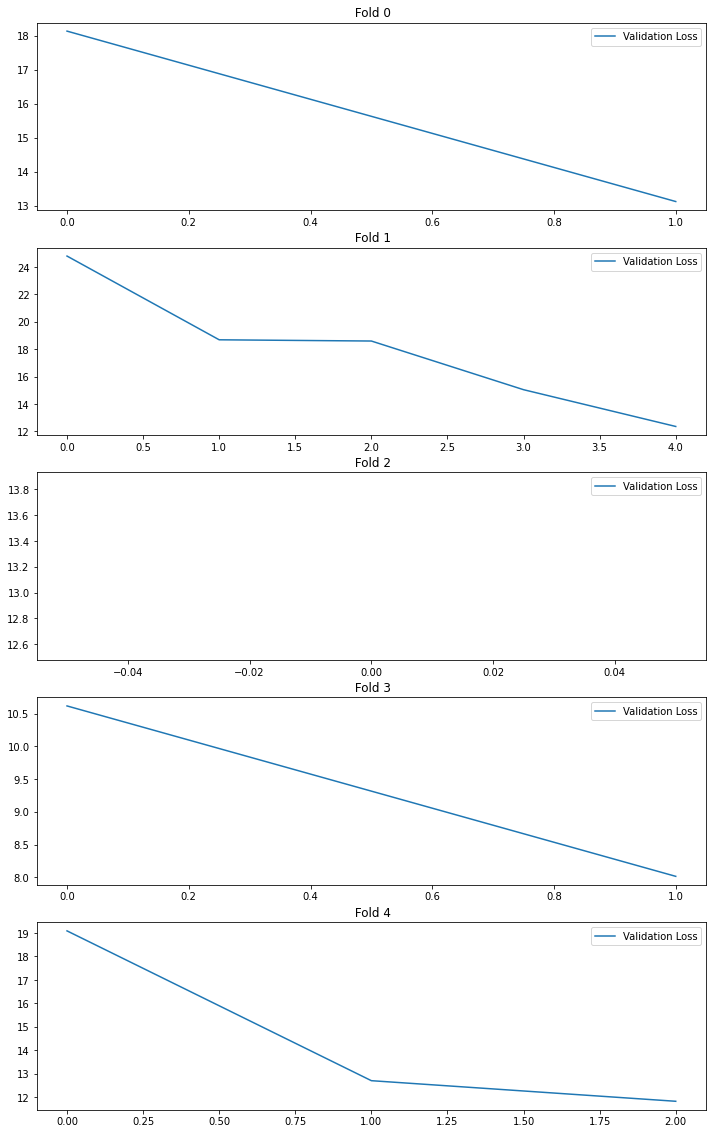

In [38]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(6, 8), dpi=80)

f, axes = plt.subplots(len(history), 1)
f.set_size_inches(12, 20)
for i in range(len(history)):
  axes[i].plot(history[i])
  #axes[i].plot(trainhistory[i])

  axes[i].legend(['Validation Loss'])
  axes[i].set_title(' Fold ' + str(i))

In [39]:
# Get best val loss scores per fold
for m in history:
  print(min(m))

13.117815
12.363038
13.204095
8.014068
11.825298


In [40]:
# Save best models
c = 0
for m in bestModels:
    torch.save(m.state_dict(), OUTPUT_MODEL_PATH + f'/tab_best_fold_{c}.pth')
    c += 1

In [41]:
for k, m in models.items():
    torch.save(m.state_dict(), OUTPUT_MODEL_PATH + f'/fold_{k}.pth')

# Testing Pipeline 

In [42]:
fold_models_directory = Path(OUTPUT_MODEL_PATH)

In [43]:
fold_models_directory.ls()[6:11]

[PosixPath('/content/drive/MyDrive/Kaggle/ModelDump/tab_best_fold_0.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/ModelDump/tab_best_fold_1.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/ModelDump/tab_best_fold_2.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/ModelDump/tab_best_fold_3.pth'),
 PosixPath('/content/drive/MyDrive/Kaggle/ModelDump/tab_best_fold_4.pth')]

In [44]:
model_device = torch.device('cpu')
for i , fold_model_path in enumerate(fold_models_directory.ls()[6:11]) :
    models[i].load_state_dict(torch.load(str(fold_model_path) , map_location = model_device), strict=False)

In [45]:
test_df['OS'] = 0

In [46]:
test_pred_dict = {}
submissionDF = pd.DataFrame()

test_ds = Dataset(path, test_df,'Test' ,0)
test_dl = torch.utils.data.DataLoader(dataset=test_ds,batch_size=1, shuffle=False,collate_fn=collate_fn)

In [47]:
encoding_dic = {k:v for k,v in dict(tuple(test_df[['id' ,'id_encoding']].groupby(['id','id_encoding']))).keys()}
decoding_dic = {v:k for k,v in encoding_dic.items()} 

In [48]:
fold_count_dict = dict(zip(test_df['id'].unique().flatten(), np.zeros(9).flatten())) # count number of occurence for a cetain patient id in the batch 
fold_mean_dict = dict(zip(test_df['id'].unique().flatten(), np.zeros(9,dtype=int).flatten())) # compute mean fold 

In [49]:
final_submit_df = pd.DataFrame(columns = fold_mean_dict.keys()) 

In [50]:
# Test Set 
for key , fold_model in models.items() : 
  print(f"=================Predictions of fold Model {key}================")
  fold_model.to(config.DEVICE)
  fold_model.eval()
  with torch.no_grad():
      for X,y,pid,_ in test_dl:
          imgs = X[0].to(config.DEVICE)
          tabs = X[1].to(config.DEVICE)
          y=y.to(config.DEVICE)
          patient_id = pid.detach().cpu().numpy()[0]
          outputs = fold_model(imgs, tabs).detach().cpu().numpy()[0]

          fold_count_dict[decoding_dic[patient_id]]+=1
          fold_mean_dict[decoding_dic[patient_id]] += outputs
           
      fold_mean_dict = {k : v / fold_count_dict[k]  for k,v in fold_mean_dict.items()}
      print ("Fold count dict : " , fold_count_dict)
      print ("Fold mean dict after dividing : " , fold_mean_dict)
    
      final_submit_df.loc[len(final_submit_df)] = [v[0] for v in fold_mean_dict.values()]
      fold_mean_dict = dict(zip(test_df['id'].unique().flatten(), np.zeros(9,dtype=int).flatten())) # reset for next fold 
      fold_count_dict = dict(zip(test_df['id'].unique().flatten(), np.zeros(9).flatten()))


=================Predictions of fold Model 0================
Fold count dict :  {'a7b285': 32.0, 'b631e6': 32.0, 'ac3e32': 32.0, 'ae0d22': 8.0, 'aabb0e': 32.0, 'ac8a8b': 32.0, 'b462ff': 32.0, 'b37b6e': 32.0, 'ad2573': 32.0}
Fold mean dict after dividing :  {'a7b285': array([46.91483], dtype=float32), 'b631e6': array([58.804962], dtype=float32), 'ac3e32': array([72.530205], dtype=float32), 'ae0d22': array([48.881138], dtype=float32), 'aabb0e': array([21.35178], dtype=float32), 'ac8a8b': array([60.773884], dtype=float32), 'b462ff': array([30.52673], dtype=float32), 'b37b6e': array([33.797863], dtype=float32), 'ad2573': array([47.877186], dtype=float32)}
=================Predictions of fold Model 1================
Fold count dict :  {'a7b285': 32.0, 'b631e6': 32.0, 'ac3e32': 32.0, 'ae0d22': 8.0, 'aabb0e': 32.0, 'ac8a8b': 32.0, 'b462ff': 32.0, 'b37b6e': 32.0, 'ad2573': 32.0}
Fold mean dict after dividing :  {'a7b285': array([38.808136], dtype=float32), 'b631e6': array([59.88478], dtype=flo

In [51]:
final_submit_df

,a7b285,b631e6,ac3e32,ae0d22,aabb0e,ac8a8b,b462ff,b37b6e,ad2573
0,46.914829,58.804962,72.530205,48.881138,21.351780,60.773884,30.526730,33.797863,47.877186
1,38.808136,59.884781,60.342625,33.614208,16.620426,58.217392,45.711250,38.543476,46.759922
2,49.681877,59.595173,63.551960,58.893845,42.345650,56.394493,44.328609,47.278938,48.491646
3,38.922997,39.751389,76.775055,55.620106,20.945906,62.641541,31.790730,35.359291,50.469067
4,45.496555,49.801739,68.785011,37.554455,25.335979,65.806145,30.262054,26.757116,45.500923


In [52]:
final_submit_df.mean(axis=0)

a7b285    43.964879
b631e6    53.567609
ac3e32    68.396971
ae0d22    46.912750
aabb0e    25.319948
ac8a8b    60.766691
b462ff    36.523875
b37b6e    36.347337
ad2573    47.819749
dtype: float64

In [53]:
final_submit_df.std(axis=0)

a7b285     4.892466
b631e6     8.785468
ac3e32     6.628973
ae0d22    11.041605
aabb0e    10.005437
ac8a8b     3.692094
b462ff     7.792634
b37b6e     7.479494
ad2573     1.869078
dtype: float64

In [54]:
submissionDF = pd.DataFrame(final_submit_df.mean(axis=0)).reset_index().rename({'index' : 'id' , 0 : 'prediction' } , axis=1 )

In [55]:
submissionDF

,id,prediction
0,a7b285,43.964879
1,b631e6,53.567609
2,ac3e32,68.396971
3,ae0d22,46.912750
4,aabb0e,25.319948
5,ac8a8b,60.766691
6,b462ff,36.523875
7,b37b6e,36.347337
8,ad2573,47.819749


In [56]:
submissionDF.to_csv("submission_V1.csv" , index = False)